In [273]:
#import libraries

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
#Load dataset
train_data = pd.read_csv('Google_Stock_Price_Train.csv')
test_data = pd.read_csv('Google_Stock_Price_Test.csv')


In [20]:
#Inspect the dataset
print(train_data.info())
print(train_data.head())

print(test_data.info())
print(test_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB
None
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null    

Since the 'Volume' and 'Close' columns in training dataset and 'Volumn' column in test dataset are not nerumic data, they will be converted to numeric in the following code.

In [21]:
#remove commas in 'Close' and 'Volume' columns and convert them to numeric
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(int)
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(int)

train_data['Close'] = train_data['Close'].str.replace(',', '').astype(float)

In [22]:
#Inspect the dataset again
print(train_data.info())
print(train_data.head())

print(test_data.info())
print(test_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
 5   Volume  1258 non-null   int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 54.2+ KB
None
       Date    Open    High     Low   Close    Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7380500
1  1/4/2012  331.27  333.87  329.08  666.45   5749400
2  1/5/2012  329.83  330.75  326.89  657.21   6590300
3  1/6/2012  328.34  328.77  323.68  648.24   5405900
4  1/9/2012  322.04  322.29  309.46  620.76  11688800
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     o

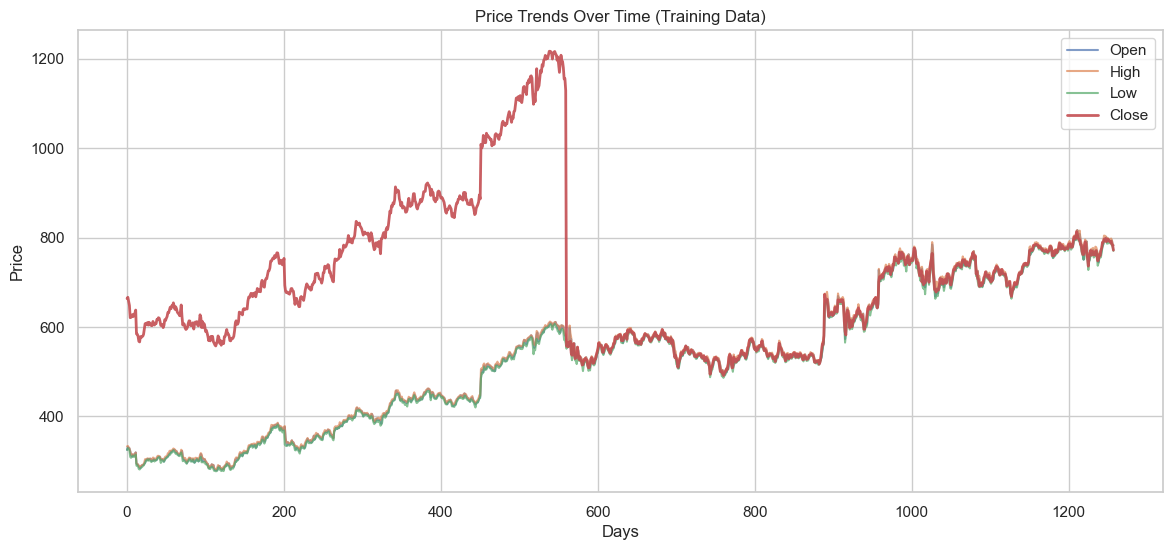

In [23]:
# Plot trends of open, high, low, and close prices of training dataset
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.plot(train_data['Open'], label='Open', alpha=0.7)
plt.plot(train_data['High'], label='High', alpha=0.7)
plt.plot(train_data['Low'], label='Low', alpha=0.7)
plt.plot(train_data['Close'], label='Close', alpha=0.9, linewidth=2)
plt.title("Price Trends Over Time (Training Data)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.savefig('original_trend.png')
plt.show()


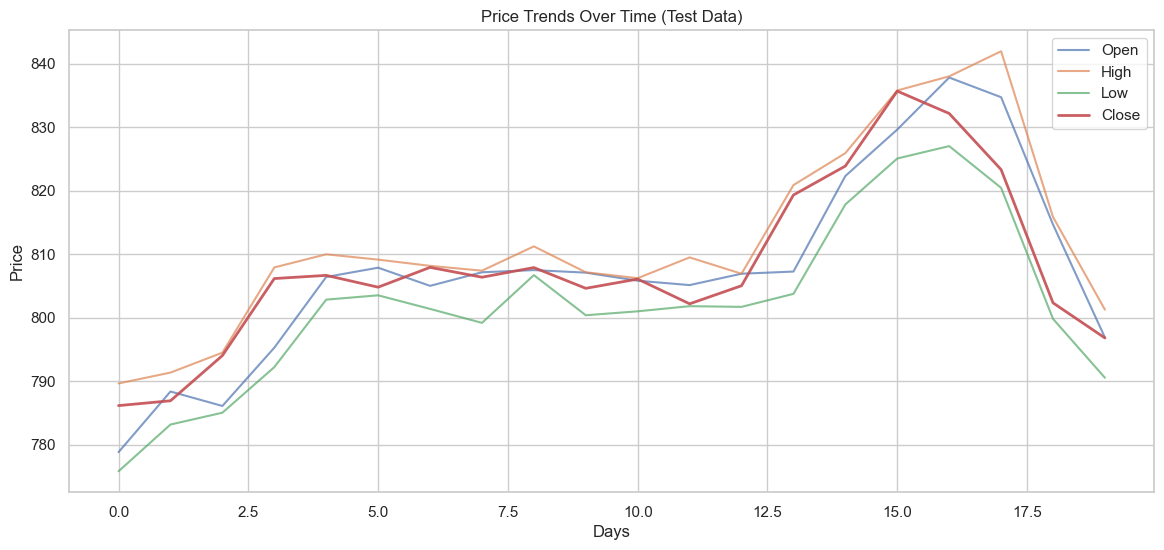

In [24]:
# Plot trends of open, high, low, and close prices of test data
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.plot(test_data['Open'], label='Open', alpha=0.7)
plt.plot(test_data['High'], label='High', alpha=0.7)
plt.plot(test_data['Low'], label='Low', alpha=0.7)
plt.plot(test_data['Close'], label='Close', alpha=0.9, linewidth=2)
plt.title("Price Trends Over Time (Test Data)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.savefig('original_trend_test.png')
plt.show()


In the training dataset, the close price have some errors in the first 500+ days. From the plot, the close prices for the first 500+ days seems have been doubled. Next, these problematic data will be divided by 2 to check if it is reasonable. 

In [25]:
#backup train_data before adjustment
train_data_copy = train_data.copy()

In [26]:
train_data['Close'] = np.where(
    train_data['Close'] > train_data['High'],  
    train_data['Close'] / 2,                  
    train_data['Close']                       
)

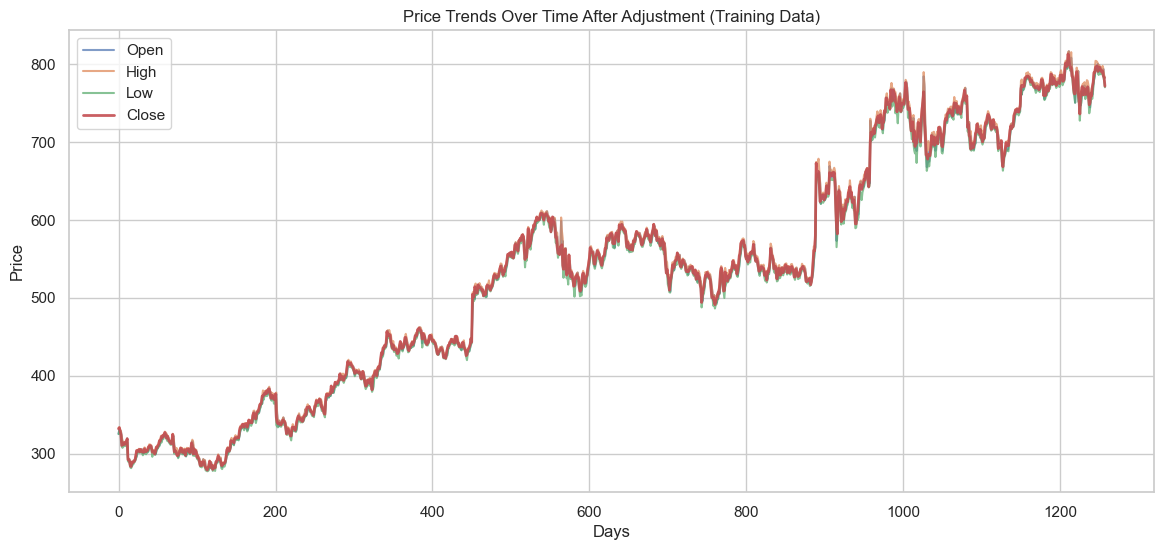

In [28]:
# Plot trends of open, high, low, and close prices of training dataset after adjustment
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.plot(train_data['Open'], label='Open', alpha=0.7)
plt.plot(train_data['High'], label='High', alpha=0.7)
plt.plot(train_data['Low'], label='Low', alpha=0.7)
plt.plot(train_data['Close'], label='Close', alpha=0.9, linewidth=2)
plt.title("Price Trends Over Time After Adjustment (Training Data)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.savefig('original_trend_after_adjustment.png')
plt.show()


The Close price seems reasonalbe after adjustment through divided by 2. However, in order to make sure the close price is error free, I further download the data of the same period of time from Yahoo Finance to compare.

In [87]:
#load google stock data from yahoo finance
google_stock_from_yahoo_train = pd.read_csv('google_stock_data.csv')

In [88]:
#drop non value rows
google_stock_from_yahoo_train = google_stock_from_yahoo_train.drop(index=[0,1])
google_stock_from_yahoo_train = google_stock_from_yahoo_train.reset_index(drop=True)

In [89]:
#convert data type
google_stock_from_yahoo_train['Volume'] = google_stock_from_yahoo_train['Volume'].str.replace(',', '').astype(int)
google_stock_from_yahoo_train['Close'] = google_stock_from_yahoo_train['Close'].str.replace(',', '').astype(float)
google_stock_from_yahoo_train['Adj Close'] = google_stock_from_yahoo_train['Adj Close'].str.replace(',', '').astype(float)
google_stock_from_yahoo_train['Open'] = google_stock_from_yahoo_train['Open'].str.replace(',', '').astype(float)
google_stock_from_yahoo_train['Low'] = google_stock_from_yahoo_train['Low'].str.replace(',', '').astype(float)
google_stock_from_yahoo_train['High'] = google_stock_from_yahoo_train['High'].str.replace(',', '').astype(float)

In [91]:
print(google_stock_from_yahoo_train.info())
print(google_stock_from_yahoo_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price      1258 non-null   object 
 1   Adj Close  1258 non-null   float64
 2   Close      1258 non-null   float64
 3   High       1258 non-null   float64
 4   Low        1258 non-null   float64
 5   Open       1258 non-null   float64
 6   Volume     1258 non-null   int32  
dtypes: float64(5), int32(1), object(1)
memory usage: 64.0+ KB
None
        Price  Adj Close      Close       High        Low       Open  \
0  2012-01-03  16.532528  16.573130  16.641375  16.248346  16.262545   
1  2012-01-04  16.603836  16.644611  16.693678  16.453827  16.563665   
2  2012-01-05  16.373516  16.413727  16.537264  16.344486  16.491436   
3  2012-01-06  16.150156  16.189817  16.438385  16.184088  16.417213   
4  2012-01-09  15.465409  15.503389  16.114599  15.472754  16.102144   

      Volume  
0  147611217  
1  

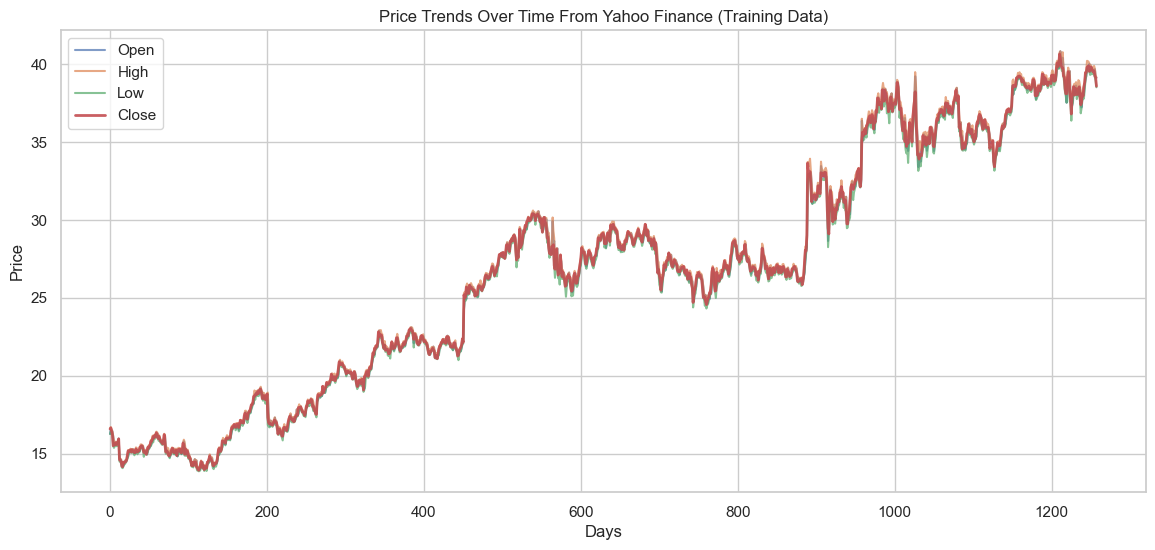

In [92]:
# Plot trend comparison between open, high, low, and close prices for data from Yahoo Finance
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.plot(google_stock_from_yahoo_train['Open'], label='Open', alpha=0.7)
plt.plot(google_stock_from_yahoo_train['High'], label='High', alpha=0.7)
plt.plot(google_stock_from_yahoo_train['Low'], label='Low', alpha=0.7)
plt.plot(google_stock_from_yahoo_train['Close'], label='Close', alpha=0.9, linewidth=2)
plt.title("Price Trends Over Time From Yahoo Finance (Training Data)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.savefig('original_trend_from_Yahoo_finance.png')
plt.show()

The price trend from yahoo Finance data looks the same trend as my adjust dataset but with different values. It seems there are a scaling between the two dataset. In order to make sure they are equal, I find the scalue factor from the first row and multiply every value of close price in yahoo finance data, and compared them with the value with the adjust close price.  

In [93]:
# calculation for scaling factor
scaling_factor = train_data['Close'].iloc[0] / google_stock_from_yahoo_train['Close'].iloc[0]
print(f"Scaling Factor: {scaling_factor}")

# Apply the scaling factor to close value of Yahoo Finance data
google_stock_from_yahoo_train['Close_Scaled'] = google_stock_from_yahoo_train['Close'] * scaling_factor

# Calculate the difference
difference = train_data['Close'] - google_stock_from_yahoo_train['Close_Scaled']

# Check if all differences are zero
if all(difference.abs() < 1e-6): 
    print("The adjusted dataset is correct! All differences are zero.")
else:
    print("There are discrepancies in the adjusted dataset.")
    print(difference[difference.abs() >= 1e-6])


Scaling Factor: 20.020056979479907
There are discrepancies in the adjusted dataset.
1      -0.001068
2       0.001254
3      -0.001067
4       0.001262
5      -0.002804
          ...   
1253   -0.792134
1254   -0.793793
1255   -0.787259
1256   -0.785013
1257   -0.774011
Length: 1256, dtype: float64


From the evaluation, there are indeed discrepancies in the adjusted data. So the following experiment will use data from Yahoo Finance rather than the prescriped dataset of the task. 

In [185]:
#load test data from yahoo finance
google_stock_from_yahoo_test = pd.read_csv('google_stock_data_test.csv')


In [186]:
# drop non-value rows
google_stock_from_yahoo_test = google_stock_from_yahoo_test.drop(index=[0,1])
google_stock_from_yahoo_test = google_stock_from_yahoo_test.reset_index(drop=True)

In [187]:
# convert data type
google_stock_from_yahoo_test['Volume'] = google_stock_from_yahoo_test['Volume'].str.replace(',', '').astype(int)
google_stock_from_yahoo_test['Close'] = google_stock_from_yahoo_test['Close'].str.replace(',', '').astype(float)
google_stock_from_yahoo_test['Adj Close'] = google_stock_from_yahoo_test['Adj Close'].str.replace(',', '').astype(float)
google_stock_from_yahoo_test['Open'] = google_stock_from_yahoo_test['Open'].str.replace(',', '').astype(float)
google_stock_from_yahoo_test['Low'] = google_stock_from_yahoo_test['Low'].str.replace(',', '').astype(float)
google_stock_from_yahoo_test['High'] = google_stock_from_yahoo_test['High'].str.replace(',', '').astype(float)

In [131]:
print(google_stock_from_yahoo_test.info())
print(google_stock_from_yahoo_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Price      210 non-null    object 
 1   Adj Close  210 non-null    float64
 2   Close      210 non-null    float64
 3   High       210 non-null    float64
 4   Low        210 non-null    float64
 5   Open       210 non-null    float64
 6   Volume     210 non-null    int32  
dtypes: float64(5), int32(1), object(1)
memory usage: 10.8+ KB
None
        Price  Adj Close      Close       High        Low       Open    Volume
0  2017-01-03  39.210705  39.306999  39.481499  38.790001  38.940498  33146000
1  2017-01-04  39.248611  39.345001  39.567001  39.158001  39.417999  21460000
2  2017-01-05  39.603741  39.701000  39.723999  39.250999  39.304001  26704000
3  2017-01-06  40.208755  40.307499  40.395000  39.610199  39.763000  32804000
4  2017-01-09  40.233692  40.332500  40.498299  40.141499  40.320000  254

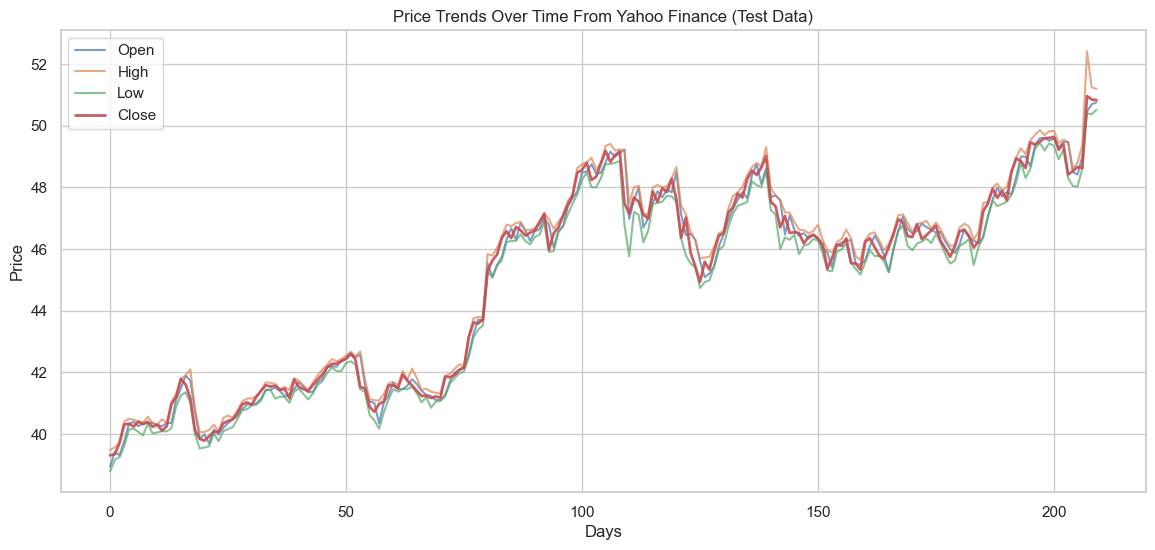

In [132]:
# Plot trends of open, high, low, and close prices of test data from yahoo finance
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.plot(google_stock_from_yahoo_test['Open'], label='Open', alpha=0.7)
plt.plot(google_stock_from_yahoo_test['High'], label='High', alpha=0.7)
plt.plot(google_stock_from_yahoo_test['Low'], label='Low', alpha=0.7)
plt.plot(google_stock_from_yahoo_test['Close'], label='Close', alpha=0.9, linewidth=2)
plt.title("Price Trends Over Time From Yahoo Finance (Test Data)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.savefig('original_trend_test_yahoo_finance.png')
plt.show()


In [98]:
print(google_stock_from_yahoo_train.info())
print(google_stock_from_yahoo_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         1258 non-null   object 
 1   Adj Close     1258 non-null   float64
 2   Close         1258 non-null   float64
 3   High          1258 non-null   float64
 4   Low           1258 non-null   float64
 5   Open          1258 non-null   float64
 6   Volume        1258 non-null   int32  
 7   Close_Scaled  1258 non-null   float64
dtypes: float64(6), int32(1), object(1)
memory usage: 73.8+ KB
None
        Price  Adj Close      Close       High        Low       Open  \
0  2012-01-03  16.532528  16.573130  16.641375  16.248346  16.262545   
1  2012-01-04  16.603836  16.644611  16.693678  16.453827  16.563665   
2  2012-01-05  16.373516  16.413727  16.537264  16.344486  16.491436   
3  2012-01-06  16.150156  16.189817  16.438385  16.184088  16.417213   
4  2012-01-09  15.465409  15.503389 

In [133]:
# normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['Open', 'High', 'Low', 'Close', 'Volume']
train_scaled = scaler.fit_transform(google_stock_from_yahoo_train[features])
test_scaled = scaler.transform(google_stock_from_yahoo_test[features])


In [110]:
print(train_scaled)

[[0.0858089  0.0964034  0.09044194 0.09909944 0.29525807]
 [0.09701223 0.09835693 0.09822649 0.10177351 0.22993645]
 [0.0943249  0.09251485 0.09408416 0.09313632 0.26361427]
 ...
 [0.95725105 0.95807448 0.9584406  0.94751499 0.04588992]
 [0.93795999 0.9425743  0.95033327 0.9432878  0.02949034]
 [0.93688106 0.93669162 0.93421341 0.92276888 0.07056738]]


In [134]:
print(test_scaled)

[[0.92955151 0.94948398 0.94442334 0.94955381 0.06605399]
 [0.94731712 0.95267751 0.95836487 0.95097543 0.04265406]
 [0.94307577 0.95854138 0.96188808 0.96429305 0.05315459]
 ...
 [1.35812068 1.43271937 1.38464226 1.38561344 0.20663784]
 [1.36706863 1.38898251 1.38331631 1.38157319 0.08318645]
 [1.36933819 1.38717102 1.38884745 1.38069413 0.05297438]]


In [114]:
# Define number of days (N) used for predition and predition next M days
N = 30 
M = 1


In [115]:
# Define a class to generate sequential input

class StockDataset(Dataset):
    def __init__(self, data, n_days):
        self.data = data
        self.n_days = n_days

    def __len__(self):
        return len(self.data) - self.n_days

    def __getitem__(self, index):
        x = self.data[index:index + self.n_days, :]
        y = self.data[index + self.n_days, :]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [135]:
#split train dataset to train_data and val_data, and convert them into sequential data
train_data, val_data = train_test_split(train_scaled, test_size=0.2, shuffle=False)
train_dataset = StockDataset(train_data, N)
val_dataset = StockDataset(val_data, N)
test_dataset = StockDataset(test_scaled, N)


In [118]:
from sklearn.model_selection import ParameterGrid

# Define hyperparameters that will be tried in the grid search
param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2, 3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32, 64]
}

In [119]:
# Define the LSTM Model inlcuding lstm layer and 1 fully connected layer
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

In [122]:
# Define the Function to train and evaluate LSTM model

def train_and_evaluate(params):
    # hyperparameters
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    num_epochs = 100
    
    # Define DataLoaders with the batch_size in the hyperparameters
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = StockLSTM(input_size=len(features), hidden_size=hidden_size, num_layers=num_layers, output_size=len(features))
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training and evaluation with early stop    
    best_val_loss = float('inf')
    best_model_state = None
    patience = 5
    wait = 0    
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        
        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                y_val_pred = model(x_val)
                val_loss += criterion(y_val_pred, y_val).item()
                
        val_loss /= len(val_loader)
        
        # Check if validation loss improved or not, record the best model and best hyperparameters
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            best_hyperparameters = params
            wait = 0
        else:
            wait += 1

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # judge if Early stopping
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

    return best_model_state, best_val_loss




In [123]:
# Perform grid search
best_loss = float('inf')
best_model_state = None
best_hyperparameters = None

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    model_state, val_loss = train_and_evaluate(params)
    print(f"Validation Loss: {val_loss:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_state = model_state
        best_hyperparameters = params

print(f"Best Hyperparameters: {best_hyperparameters}")
print(f"Best Validation Loss: {best_loss:.4f}")

# Save the best model
torch.save(best_model_state, "best_lstm_model.pth")
print("Best model saved as 'best_lstm_model.pth'")



Testing parameters: {'batch_size': 16, 'hidden_size': 32, 'learning_rate': 0.001, 'num_layers': 1}
Epoch 1/100, Train Loss: 0.0795, Val Loss: 0.0401
Epoch 2/100, Train Loss: 0.0058, Val Loss: 0.0051
Epoch 3/100, Train Loss: 0.0024, Val Loss: 0.0037
Epoch 4/100, Train Loss: 0.0019, Val Loss: 0.0024
Epoch 5/100, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 6/100, Train Loss: 0.0017, Val Loss: 0.0011
Epoch 7/100, Train Loss: 0.0016, Val Loss: 0.0017
Epoch 8/100, Train Loss: 0.0016, Val Loss: 0.0007
Epoch 9/100, Train Loss: 0.0015, Val Loss: 0.0008
Epoch 10/100, Train Loss: 0.0015, Val Loss: 0.0008
Epoch 11/100, Train Loss: 0.0016, Val Loss: 0.0007
Epoch 12/100, Train Loss: 0.0016, Val Loss: 0.0017
Epoch 13/100, Train Loss: 0.0015, Val Loss: 0.0007
Epoch 14/100, Train Loss: 0.0014, Val Loss: 0.0014
Epoch 15/100, Train Loss: 0.0014, Val Loss: 0.0006
Epoch 16/100, Train Loss: 0.0014, Val Loss: 0.0007
Epoch 17/100, Train Loss: 0.0014, Val Loss: 0.0006
Epoch 18/100, Train Loss: 0.0014, Val Loss:

C:\Users\yangl\AppData\Local\Temp\ipykernel_46444\67840552.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_lstm_model.pth"))


Open Price -> MSE: 0.5366, MAE: 0.5893, RMSE: 0.7325, R²: 0.9280
High Price -> MSE: 0.4705, MAE: 0.5120, RMSE: 0.6859, R²: 0.9391
Low Price -> MSE: 0.8612, MAE: 0.7992, RMSE: 0.9280, R²: 0.8789
Close Price -> MSE: 0.5651, MAE: 0.6042, RMSE: 0.7517, R²: 0.9235
Volume -> MSE: 229515552882688.0000, MAE: 10458219.0000, RMSE: 15149771.0000, R²: -0.3017


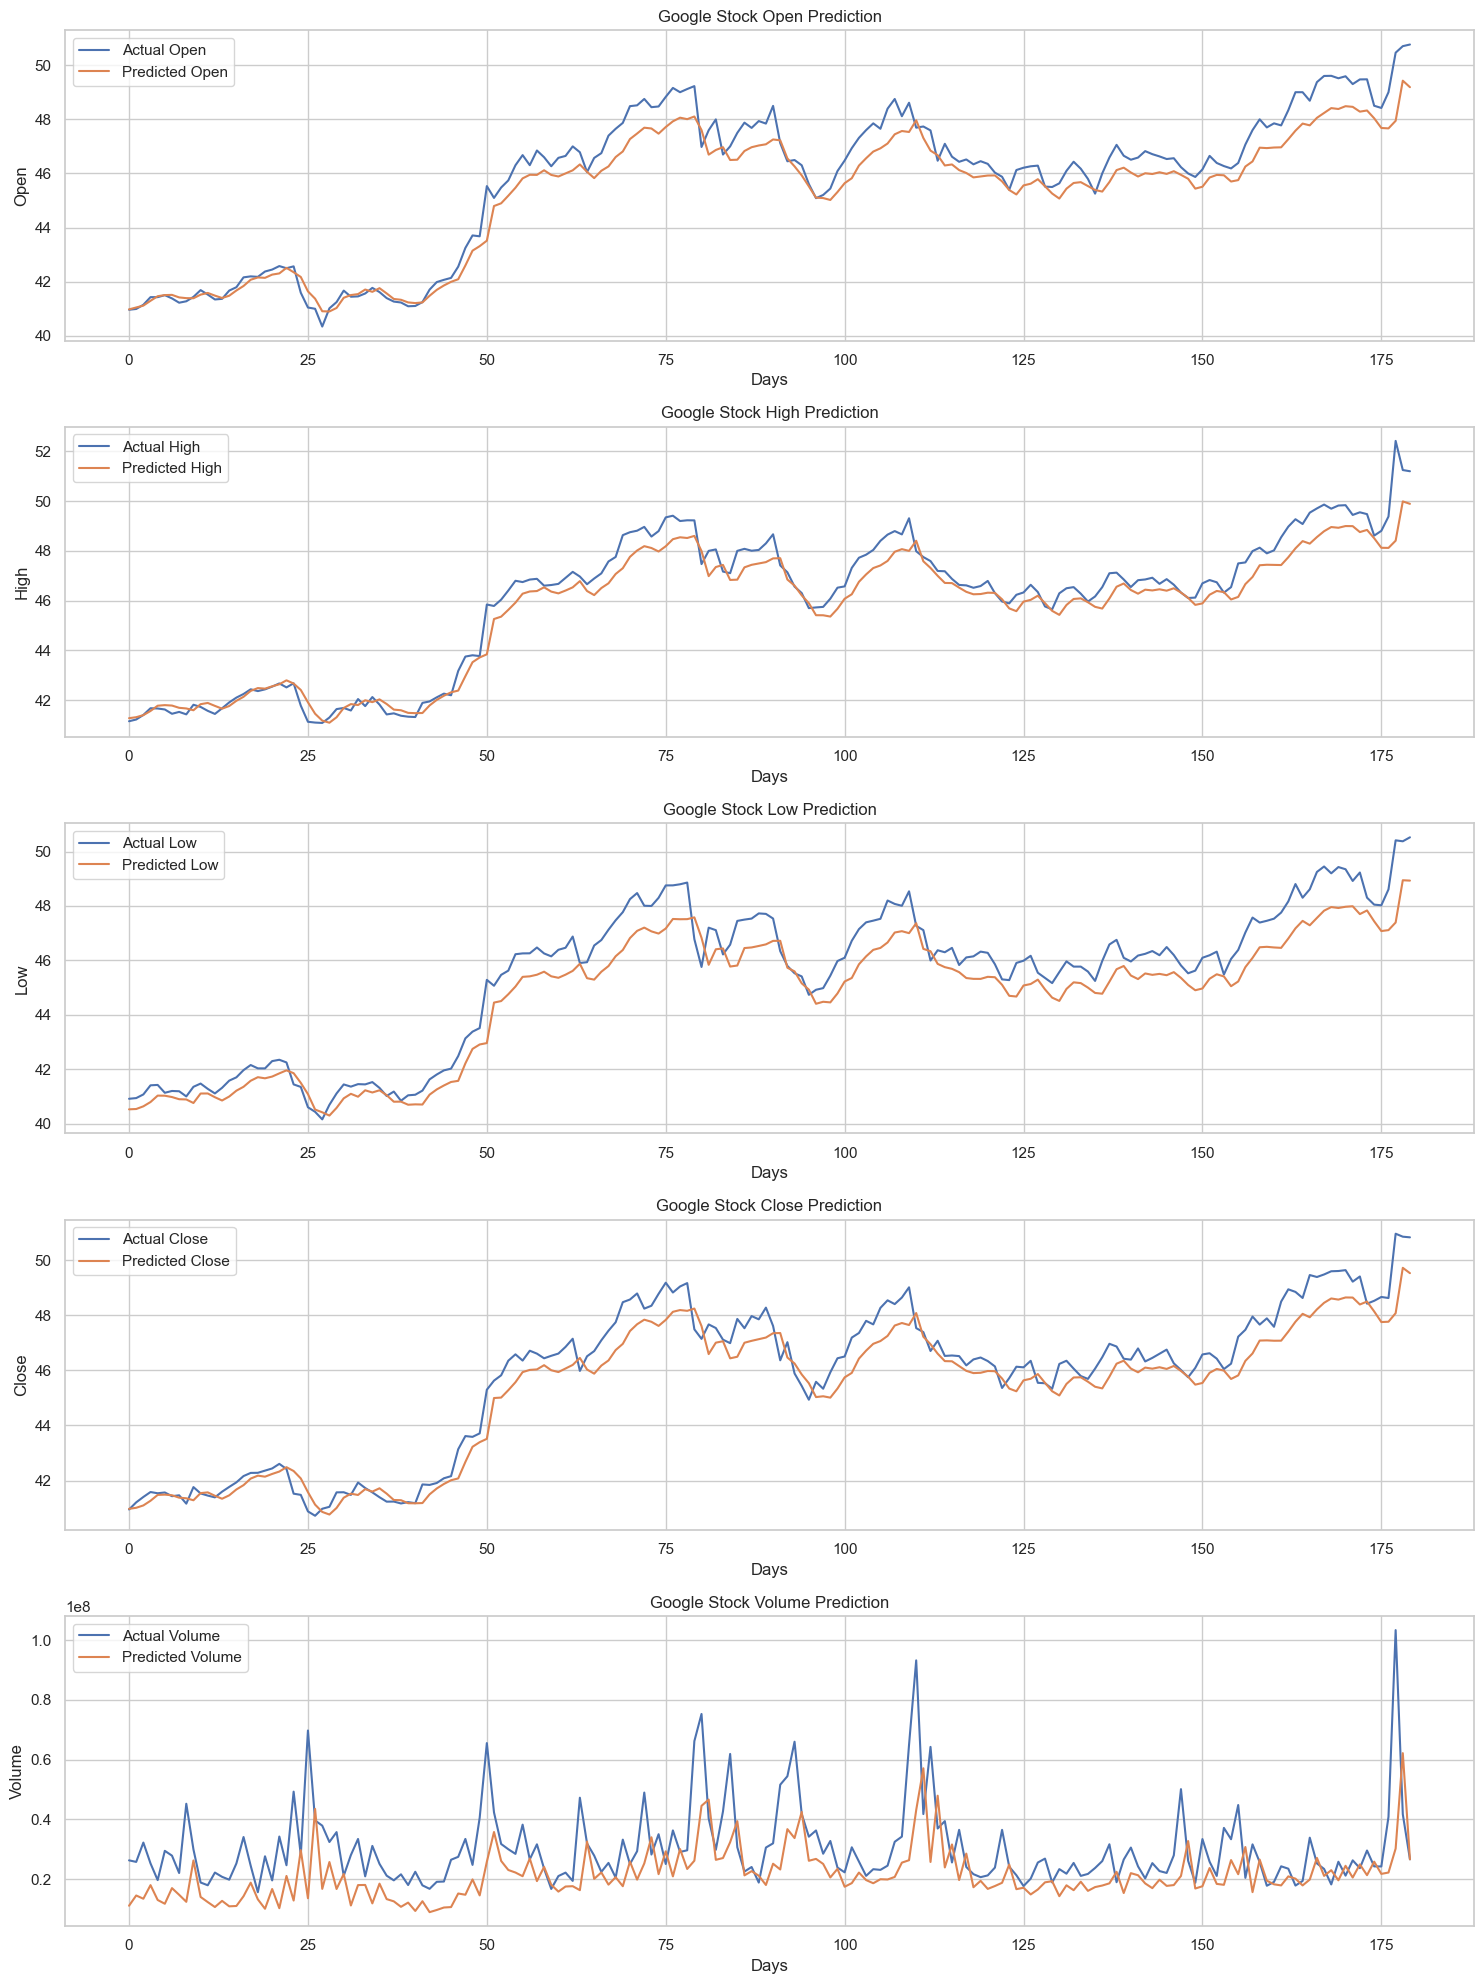

In [274]:
# Load the saved state dictionary
best_model = StockLSTM(
    input_size=len(features),
    hidden_size=32,
    num_layers=1,
    output_size=len(features)
)
best_model.load_state_dict(torch.load("best_lstm_model.pth"))

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#define test model function
def test_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x_test, y_test in test_loader:
            y_pred = model(x_test)  # Shape: [batch_size, num_features]
            predictions.append(y_pred.numpy().reshape(-1, y_pred.shape[-1]))  # Flatten predictions
            actuals.append(y_test.numpy().reshape(-1, y_test.shape[-1]))  # Flatten actuals

    # Concatenate all batches
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    # Rescale back to original values
    predictions = scaler.inverse_transform(predictions)
    actuals = scaler.inverse_transform(actuals)

    return predictions, actuals


# Testing with the best model
predictions, actuals = test_model(best_model, test_loader)

# Evaluate Performance for Open Price
mse_open = mean_squared_error(actuals[:, 0], predictions[:, 0])
mae_open = mean_absolute_error(actuals[:, 0], predictions[:, 0])
rmse_open = np.sqrt(mse_open)
r2_open = r2_score(actuals[:, 0], predictions[:, 0])
print(f"Open Price -> MSE: {mse_open:.4f}, MAE: {mae_open:.4f}, RMSE: {rmse_open:.4f}, R²: {r2_open:.4f}")

# Evaluate Performance for High Price
mse_high = mean_squared_error(actuals[:, 1], predictions[:, 1])
mae_high = mean_absolute_error(actuals[:, 1], predictions[:, 1])
rmse_high = np.sqrt(mse_high)
r2_high = r2_score(actuals[:, 1], predictions[:, 1])
print(f"High Price -> MSE: {mse_high:.4f}, MAE: {mae_high:.4f}, RMSE: {rmse_high:.4f}, R²: {r2_high:.4f}")

# Evaluate Performance for Low Price
mse_low = mean_squared_error(actuals[:, 2], predictions[:, 2])
mae_low = mean_absolute_error(actuals[:, 2], predictions[:, 2])
rmse_low = np.sqrt(mse_low)
r2_low = r2_score(actuals[:, 2], predictions[:, 2])
print(f"Low Price -> MSE: {mse_low:.4f}, MAE: {mae_low:.4f}, RMSE: {rmse_low:.4f}, R²: {r2_low:.4f}")

# Evaluate Performance for Close Price
mse_close = mean_squared_error(actuals[:, 3], predictions[:, 3])
mae_close = mean_absolute_error(actuals[:, 3], predictions[:, 3])
rmse_close = np.sqrt(mse_close)
r2_close = r2_score(actuals[:, 3], predictions[:, 3])
print(f"Close Price -> MSE: {mse_close:.4f}, MAE: {mae_close:.4f}, RMSE: {rmse_close:.4f}, R²: {r2_close:.4f}")

# Evaluate Performance for Volume
mse_volume = mean_squared_error(actuals[:, 4], predictions[:, 4])
mae_volume = mean_absolute_error(actuals[:, 4], predictions[:, 4])
rmse_volume = np.sqrt(mse_volume)
r2_volume = r2_score(actuals[:, 4], predictions[:, 4])
print(f"Volume -> MSE: {mse_volume:.4f}, MAE: {mae_volume:.4f}, RMSE: {rmse_volume:.4f}, R²: {r2_volume:.4f}")

# Visualize Results

plt.figure(figsize=(15, 20))  # Adjust the figure size to fit all subplots

for i, feature in enumerate(features):
    plt.subplot(5, 1, i + 1)  # Create a subplot for each feature
    plt.plot(actuals[:, i], label=f'Actual {feature}')
    plt.plot(predictions[:, i], label=f'Predicted {feature}')
    plt.title(f'Google Stock {feature} Prediction')
    plt.xlabel('Days')
    plt.ylabel(feature)
    plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

To make the model practically useful, a trading strategy will be developed. The strategy uses two thresholds: one for buying and one for selling. A "Buy" command will be triggered if the predicted close price is expected to increase beyond the buy threshold, while a "Sell" command will be issued if the predicted close price is expected to decrease beyond the sell threshold. 







In [269]:
#define trading_strategy to generate Buy, Sell or Hold commend

def trading_strategy(actuals, predictions, threshold_buy=0.01, threshold_sell=0.01):
    signals = []
    for i in range(len(actuals) - 1):
        # Today's actual Close price
        actual_close_today = actuals[i, 3]  
        
        # Tomorrow's predicted Close price
        predicted_close_tomorrow = predictions[i + 1, 3]  
        
        # Calculate the percentage change
        change = (predicted_close_tomorrow - actual_close_today) / actual_close_today
        
        if change > threshold_buy:
            signals.append("Buy")
            
        elif change < -threshold_sell:
            signals.append("Sell")
        else:
            signals.append("Hold")
    
    return signals


In [270]:
#define simulate_trading to simulate trading based on the trading strategy

def simulate_trading(actuals, predictions, signals, initial_balance=10000):
    # Cash balance
    balance = initial_balance  
    # Number of shares owned
    holdings = 0  
    # Track portfolio value
    portfolio_values = []  
    buy_n = 0
    sell_n = 0

    for i in range(len(signals)):
        # Today's actual Close price
        actual_close_price = actuals[i, 3]          
        if signals[i] == "Buy" and balance > 0:
            # Buy as many shares as possible
            holdings += balance / actual_close_price            
            balance = 0  
            buy_n += 1
        
        elif signals[i] == "Sell" and holdings > 0:
            # Sell all holdings
            balance += holdings * actual_close_price
            holdings = 0 
            sell_n += 1
        
        # Calculate total portfolio value (cash + holdings)
        portfolio_value = balance + holdings * actual_close_price
        portfolio_values.append(portfolio_value)
    return portfolio_values


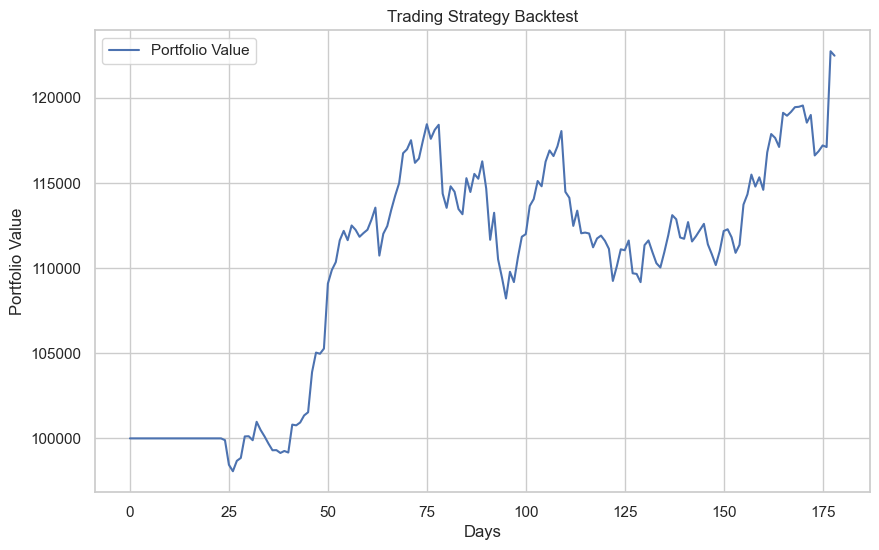

Total Returns: 22.48%


In [272]:
# Generate trading signals using trading strategy function
# If the market is bull market, set buy threshold bigger than sell threshold. 
# If the market is bear market, set but threshold smaller than sell threshold.

signals = trading_strategy(actuals, predictions, threshold_buy=0.01, threshold_sell=0.03)

# Simulate the trading strategy
initial_balance = 100000
portfolio_values = simulate_trading(actuals, predictions, signals, initial_balance=initial_balance)

# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(portfolio_values, label="Portfolio Value")
plt.title("Trading Strategy Backtest")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.show()

#calculate the total return
total_returns = (portfolio_values[-1] - initial_balance) / initial_balance
print(f"Total Returns: {total_returns:.2%}")

### conclusion
The return is acceptable given the market situation. Furture testing is required to evaluate the model and strategy.